In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# K-means

In [2]:
from scipy.spatial import distance
def Kmeans(X, K=3, distance=distance.euclidean,  n_iter=1e+4, tol=None, 
           scale="max", plot=False):
    if scale=="standard":
        X = 1.* (X - X.mean(axis=0)) / X.std(axis=0)
    if scale=="max":
        X = 1. * X/X.max()
    m = len(X)
    centers = X[np.random.randint(0, m, K), : ]
    new_centers = np.zeros((K, X.shape[1]))
    # indices tells to which center belongs each point
    indices = np.zeros(m)
    for a in range(n_iter):
        for i, point in enumerate(X):
            distance_to_centers = [distance(point, center) for center in centers]
            indices[i] = np.argmin(distance_to_centers)
        
        for i in range(K):
            new_centers[i] = X[indices==i].mean(axis=0)
            
        if tol and np.max([distance(new_centers[j], centers[j]) for j in range(K)]) < tol:
            centers = new_centers
            break
        
        centers = new_centers
    if plot: 
        plt.scatter(centers[:,0], centers[:,1], marker='x', c='black', s=50, alpha=1)
        plt.scatter(X[:,0], X[:,1], c=indices, alpha=0.5)
        plt.show()

    return centers, indices
            
        
        

(300, 2)


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


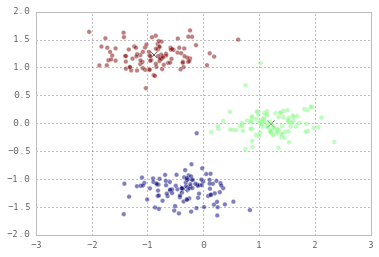

('centers', array([[-0.33801725, -1.1820774 ],
       [ 1.21726404, -0.00858381],
       [-0.88471375,  1.21462826]]))
('np.unique(indices)', array([ 0.,  1.,  2.]))


In [3]:
import scipy.io
a = scipy.io.loadmat('mlclass-ex7/ex7data2.mat')
X = a['X']
print(X.shape)
centers, indices = Kmeans(X, K=3, scale='standard', distance=distance.euclidean,  n_iter=200, 
                         plot=True)
print("centers", centers)
print("np.unique(indices)", np.unique(indices))

# K-means to reduce number of colors of an image, so that it fits in memory better

(<type 'numpy.ndarray'>, (128, 128, 3))


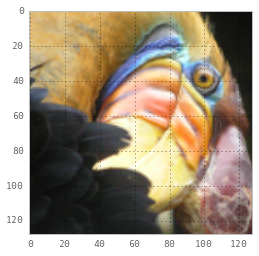

In [4]:
# 128 x 128 pixels. 3 colors (RGB). Color"intensity/tone" is described by a number 
# within the range 0-255. As 256=2**8, each color requires 8 bits. Overall we need
# 128x128x3x8 bits (393216 bits)
from scipy import misc
A = misc.imread('mlclass-ex7/bird_small.png')
print(type(A), A.shape)
plt.imshow(A)

In [5]:
# Let reshape the array in such a way that we have all pixels (horizontal and vertical) 
# in rows and colors in columns
m = A.shape[0]*A.shape[1]
X = A.reshape(m, A.shape[2])
print(type(X), X.shape)

(<type 'numpy.ndarray'>, (16384, 3))


## Centers contain the k=16 most meaningful color combinations (clusters). indices assign each pixel of the original image to one of the 16 clusters (each of cluster requires 3x8 bits, but each pixel now requires only 4 bits, as 2**4=16). So the number of bits we are using is 16x3x8 + 128x128x4 = 65920, which is the 17% of the original image

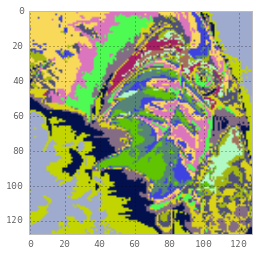

In [6]:
# The recovered image is bad
centers, indices = Kmeans(X, K=16, scale="standard", n_iter=10)
indices = map(lambda x: int(x), indices)
X_recovered = centers[indices,:]
X_recovered = X_recovered.reshape(A.shape[0], A.shape[1], 3)
plt.imshow(X_recovered);

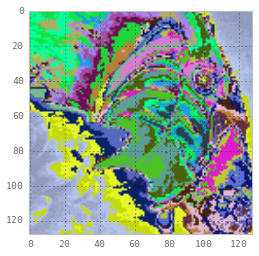

In [7]:
# Again, the recovered image is bad, even with 30 centers. As we will see the reason is
# we are using standard scaling, rather than dividing by the maximum value, so that all
# values are within the range 0 to 1

centers, indices = Kmeans(X, K=30, scale="standard",  n_iter=10)
indices = map(lambda x: int(x), indices)
X_recovered = centers[indices,:]
X_recovered = X_recovered.reshape(A.shape[0], A.shape[1], 3)
plt.imshow(X_recovered);

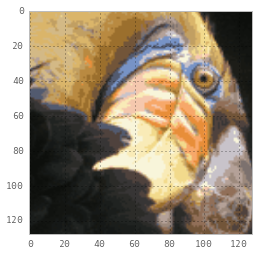

In [8]:
# Much better with max scaling

centers, indices = Kmeans(X, K=30, scale="max",  n_iter=10)
indices = map(lambda x: int(x), indices)
X_recovered = centers[indices,:]
X_recovered = X_recovered.reshape(A.shape[0], A.shape[1], 3)
plt.imshow(X_recovered);

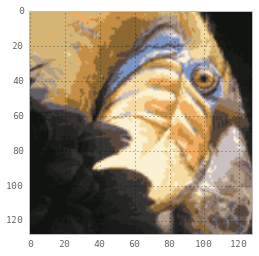

In [9]:
# Even for K=16 the recovered image is quite good

centers, indices = Kmeans(X, K=16, scale="max", n_iter=10)
indices = map(lambda x: int(x), indices)
X_recovered = centers[indices,:]
X_recovered = X_recovered.reshape(A.shape[0], A.shape[1], 3)
plt.imshow(X_recovered);

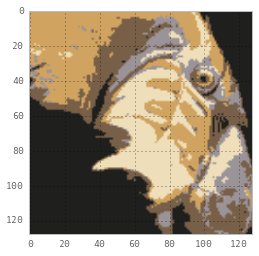

In [10]:
# K=5 and max scaling beats K=30 and standard scaling

centers, indices = Kmeans(X, K=5, scale="max", n_iter=10)
indices = map(lambda x: int(x), indices)
X_recovered = centers[indices,:]
X_recovered = X_recovered.reshape(A.shape[0], A.shape[1], 3)
plt.imshow(X_recovered);

# PCA

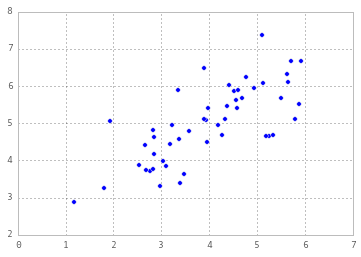

In [11]:
# Plot data
import scipy.io
X = scipy.io.loadmat('mlclass-ex7/ex7data1.mat')
X = X['X']
plt.scatter(X[:,0], X[:,1]);

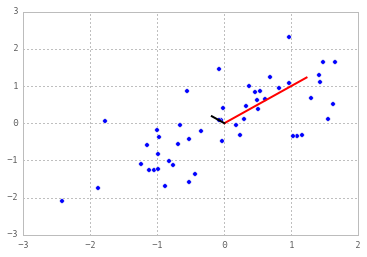

In [12]:
# Plot centered data and principal components
from numpy import linalg
# scale data
mu = X.mean(axis=0)
X = 1.*(X - mu)/X.std(axis=0)
# Covariance matrix
m = X.shape[0]
Sigma = 1./m * np.dot(X.T, X)
# Compute eigenvalues and eigenvectors
s, u = linalg.eig(Sigma)
# u[:, k] is the eigenvector corresponding to the kth eigenvalue in s
# Eigenvalues in s aren't sorted by value
mu = X.mean(axis=0)
plt.scatter(X[:,0], X[:,1])
plt.plot([mu[0],mu[0]+s[0]*u[0,0]], [mu[1], mu[1]+s[0]*u[1,0]], 'r', linewidth=2)
plt.plot([mu[0],mu[0]+s[1]*u[0,1]], [mu[1], mu[1]+s[1]*u[1,1]], 'k', linewidth=2)
plt.show();


In [13]:
# Define function to project data onto lower dimensional space
from numpy import linalg
def project_data(X, k, scaling='standard'):
    # scale data
    if scaling == 'max':
        X = 1. * X/X.max()
    elif scaling == 'standard':
        mu = X.mean(axis=0)
        X = 1.*(X - mu)/X.std(axis=0)
    # Covariance matrix
    m = X.shape[0]
    Sigma = 1./m * np.dot(X.T, X)
    # Compute eigenvalues and eigenvectors
    s, U = linalg.eig(Sigma)
    idx = np.argsort(s)
    idx = idx[::-1][:k]
    U_red = U[:,idx]
    Z = np.dot(X, U_red)
    return Z, U_red

In [14]:
Z, U_red = project_data(X, 1)
Z[0]

array([-1.49631261])

In [15]:
# Define function to reconstruct from projected data to original 
# higher-dimensional space
def recover_data(Z, U_red):
    X_approx = np.dot(Z, U_red.T)
    return X_approx

In [16]:
X_app = recover_data(Z, U_red)
X_app[0]

array([-1.05805279, -1.05805279])

In [17]:
# sanity check: if the number of principal components 
# (= dimension of low dimensional space) equals the dimensions 
# of the high dimensional space, the reconstructed data, x_app,
# must be the same as the original, X.
z, u_red = project_data(X, k=2)
x_app = recover_data(z, u_red)
X[(X-x_app)>1e-15]

array([-1.59279252, -0.58315891, -1.27071783, -0.81658417, -1.35221333,
        0.09440201, -0.04748911, -0.33689741, -1.21879564, -0.37147508,
       -0.35168199, -0.19743438, -0.30931801, -1.1038306 , -0.05946964,
       -0.18146695,  0.09629619, -1.13086421, -0.31789212, -0.43176175,
       -1.25536309, -1.73253268,  0.10689618, -0.55861538, -1.01074999,
       -1.68050588, -2.09660014,  0.06738835, -0.49103538])

# PCA for dimensional reduction in photo dataset

(5000, 1024)


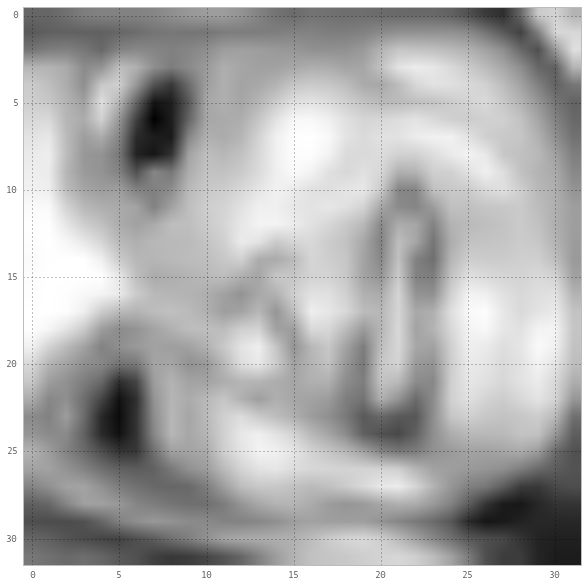

In [18]:
# Image contains 5000 facial photos in gray scale (only one color).
# Each photo contains 32x32 pixels. Nothe that now we have phtos in rows
# and pixels in columns. Should we have more than one color, we would
# need to add more columns (32x32 for each additional color)
import scipy.io
X = scipy.io.loadmat('mlclass-ex7/ex7faces.mat')
X = X['X']
print X.shape
plt.figure(figsize=(10,10))
#plot one photo (needs to be rotated)
plt.imshow(X[10,:].reshape((32,32)), cmap='gray')
plt.show();

## We are going to use the 5000 photos (rows) to project the photos from the original 1024 dim-space (=# pixels) onto a lower dim-space of only 100 dimensions (like 10x10 pixels)

(5000, 100) (1024, 100)


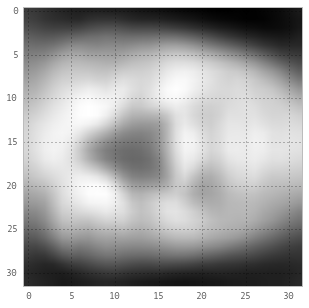

In [19]:
Z, U_red=project_data(X, 100)
print Z.shape, U_red.shape
plt.figure(figsize=(5,5))
#plot one principal component (needs to be rotated)
plt.imshow(U_red[:,2].reshape((32,32)), cmap='gray')
plt.show();

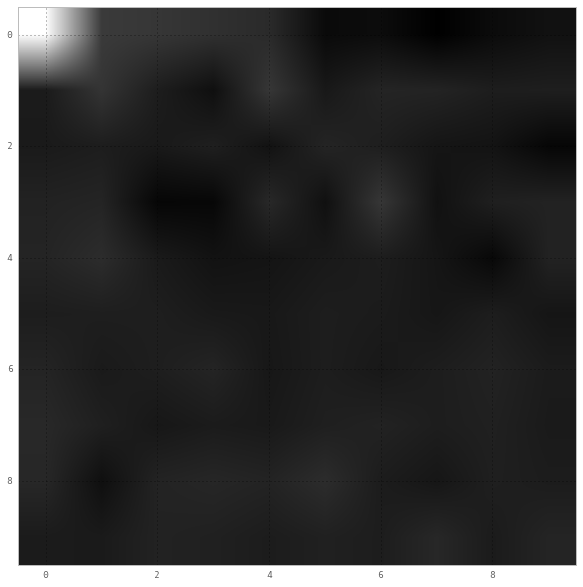

In [20]:
# same photo as the first, projected in 100 dimensional space
plt.figure(figsize=(10,10))
plt.imshow(Z[10,:].reshape((10,10)), cmap='gray')
plt.show();

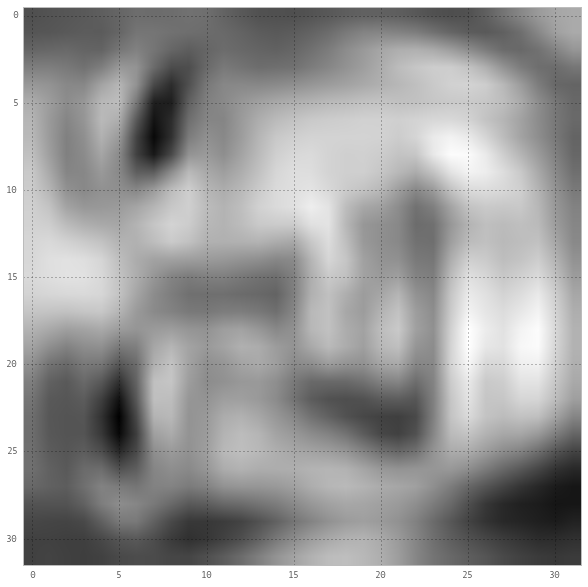

In [21]:
# reconstructed the same photo. General appeareance is kept while details are lost.
# Note that original image required 5000x1024 components, while reconstructed image requires
# 5000x100 (Z) + 1024x100 (U_red). That is, about 10% of the original components
X_app = recover_data(Z, U_red)
plt.figure(figsize=(10,10))
plt.imshow(X_app[10,:].reshape((32,32)), cmap='gray')
plt.show();

(5000, 1024) (1024, 1024)


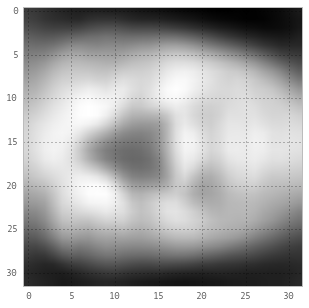

In [22]:
# Let's see what happen if we project onto a space of the same number of dismensions
Z, U_red=project_data(X, 1024)
print Z.shape, U_red.shape
plt.figure(figsize=(5,5))
#plot one principal component (needs to be rotated)
plt.imshow(U_red[:,2].reshape((32,32)), cmap='gray')
plt.show();

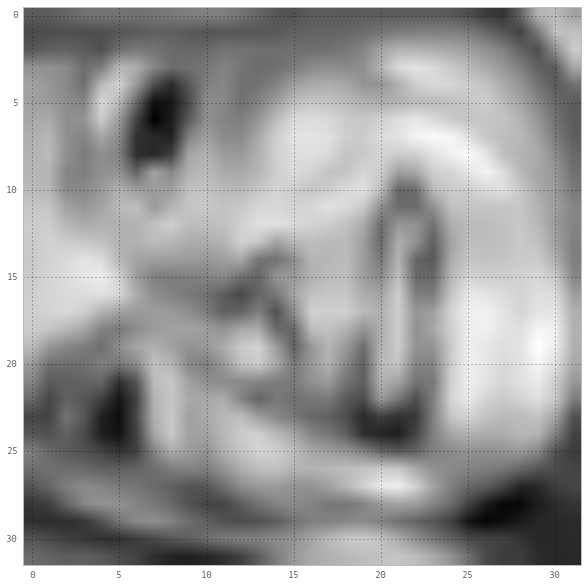

In [23]:
# reconstructed image. We do check the image is the same as the original. OK
X_app = recover_data(Z, U_red)
plt.figure(figsize=(10,10))
plt.imshow(X_app[10,:].reshape((32,32)), cmap='gray')
plt.show();

## kmeans to photo above

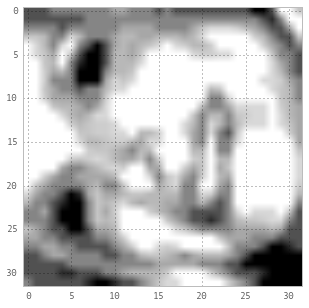

In [24]:
# Let's apply k-means to the above photo X[10,:]. Note that now we aren't 
# reducing the number of pixels, but the number of diferent intensities/tones
# in the gray scale. We are going to keep only 10 different gray tones. 
import scipy.io
X = scipy.io.loadmat('mlclass-ex7/ex7faces.mat')
X = X['X']
X = X[10,:].reshape((1,1024)) # otherwise shape (,1024)
X = X.T #We want pixels in rows
# both max and standard scaling work
centers, indices = Kmeans(X, K=10, scale="max", n_iter=1)
indices = map(lambda x: int(x), indices)
X_recovered = centers[indices,:]
# We reshape the pixels from 1024 to 32x32
X_recovered = X_recovered.reshape((32,32))
plt.figure(figsize=(5,5))
plt.imshow(X_recovered, cmap='gray');

(16384, 1) (3, 1)
(16384, 3)


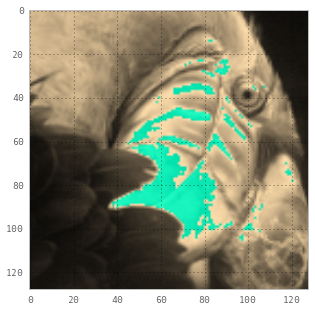

In [25]:
# Let's apply PCA to the bird. Reducing 3 colors (RGB) to 1 linear combination of them.
# There are still many intesities/tones of that single color, though.
from scipy import misc
A = misc.imread('mlclass-ex7/bird_small.png')
X = A.reshape((A.shape[0]*A.shape[1], A.shape[2]))
# We must use max scaling. Standard is worse in this case
Z, U_red = project_data(X, k=1, scaling='max')
print Z.shape, U_red.shape
X_app = recover_data(Z, U_red)
print X_app.shape
plt.figure(figsize=(5,5))
plt.imshow(X_app.reshape((A.shape[0],A.shape[1], 3)))
plt.show();

## Apply K-means to a new image

(<type 'numpy.ndarray'>, (128, 128, 3))


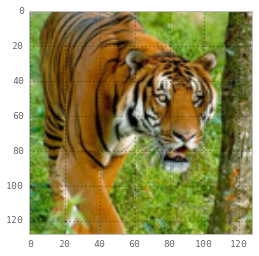

In [26]:
from scipy import misc
A = misc.imread('mlclass-ex7/small_tiger.png')
print(type(A), A.shape)
plt.imshow(A)

(<type 'numpy.ndarray'>, (16384, 3))


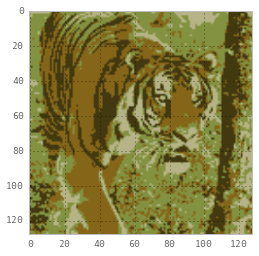

In [27]:
# Let reshape the array in such a way that we have all pixels (horizontal and vertical) 
# in rows and colors in columns
m = A.shape[0]*A.shape[1]
X = A.reshape(m, A.shape[2])
print(type(X), X.shape)
# Even for K=4 the recovered image is quite good
centers, indices = Kmeans(X, K=4, scale="max", n_iter=10)
indices = map(lambda x: int(x), indices)
X_recovered = centers[indices,:]
X_recovered = X_recovered.reshape(A.shape[0], A.shape[1], 3)
plt.imshow(X_recovered);